In [ ]:
!nvidia-smi

Thu Apr 21 10:19:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('content')

Mounted at content


In [ ]:
!unzip /content/content/MyDrive/NLM-MontgomeryCXRSet.zip

Archive:  /content/content/MyDrive/NLM-MontgomeryCXRSet.zip
   creating: MontgomerySet/
   creating: MontgomerySet/ClinicalReadings/
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0001_0.txt  
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0002_0.txt  
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0003_0.txt  
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0004_0.txt  
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0005_0.txt  
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0006_0.txt  
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0008_0.txt  
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0011_0.txt  
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0013_0.txt  
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0015_0.txt  
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0016_0.txt  
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0017_0.txt  
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0019_0.txt  
  inflating: MontgomerySet/Clinical

In [ ]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
import os 
import glob
from sklearn.model_selection import train_test_split

- Binary classification each pixel
- Image preprocessing scale [0:1]
- Loss function `binary_crossentropy`
# Model architecture
![unet](img/u-net-architecture.png)

In [ ]:
from tensorflow.keras.layers import  Input, Conv2D,MaxPooling2D,UpSampling2D,Dropout,Dense,concatenate
from tensorflow.keras import Model

In [ ]:
input_size = (512,512,3)

In [ ]:
# encode
inputs =Input(input_size)
# i = 1
conv1 = Conv2D(64,3,activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64,3,activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size = (2,2))(conv1)
# i = 2
conv2 = Conv2D(128,3,activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128,3,activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size = (2,2))(conv2)
# i = 3
conv3 = Conv2D(256,3,activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256,3,activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size = (2,2))(conv3)
# i = 4
conv4 = Conv2D(512,3,activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512,3,activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size = (2,2))(drop4)
# i = 5
conv5 = Conv2D(1024,3,activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024,3,activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)
# decode
# i = 5
up6  = UpSampling2D(size = (2,2))(drop5)
up6 = Conv2D(512,2,activation='relu',padding = 'same',kernel_initializer = 'he_normal')(up6)
merge6 = concatenate([drop4,up6],axis = 3)
conv6 = Conv2D(512,3,activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512,3,activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')(conv6)
# i = 4
up7 = Conv2D(256,1,activation='relu',padding = 'same',kernel_initializer = 'he_normal')\
    (UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7],axis = 3)
conv7 = Conv2D(256,3,activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256,3,activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')(conv7)
# i = 3
up8 = Conv2D(128,2,activation='relu',padding = 'same',kernel_initializer = 'he_normal')\
    (UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8],axis = 3)
conv8 = Conv2D(128,3,activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128,3,activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')(conv8)
# i = 2
up9 = Conv2D(64,2,activation='relu',padding = 'same',kernel_initializer = 'he_normal')\
    (UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9],axis = 3)
conv9 = Conv2D(64,3,activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64,3,activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(64,3,activation = 'relu',padding = 'same',kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1,1,activation='sigmoid')(conv9)

model = Model(inputs  =inputs,outputs = conv10)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

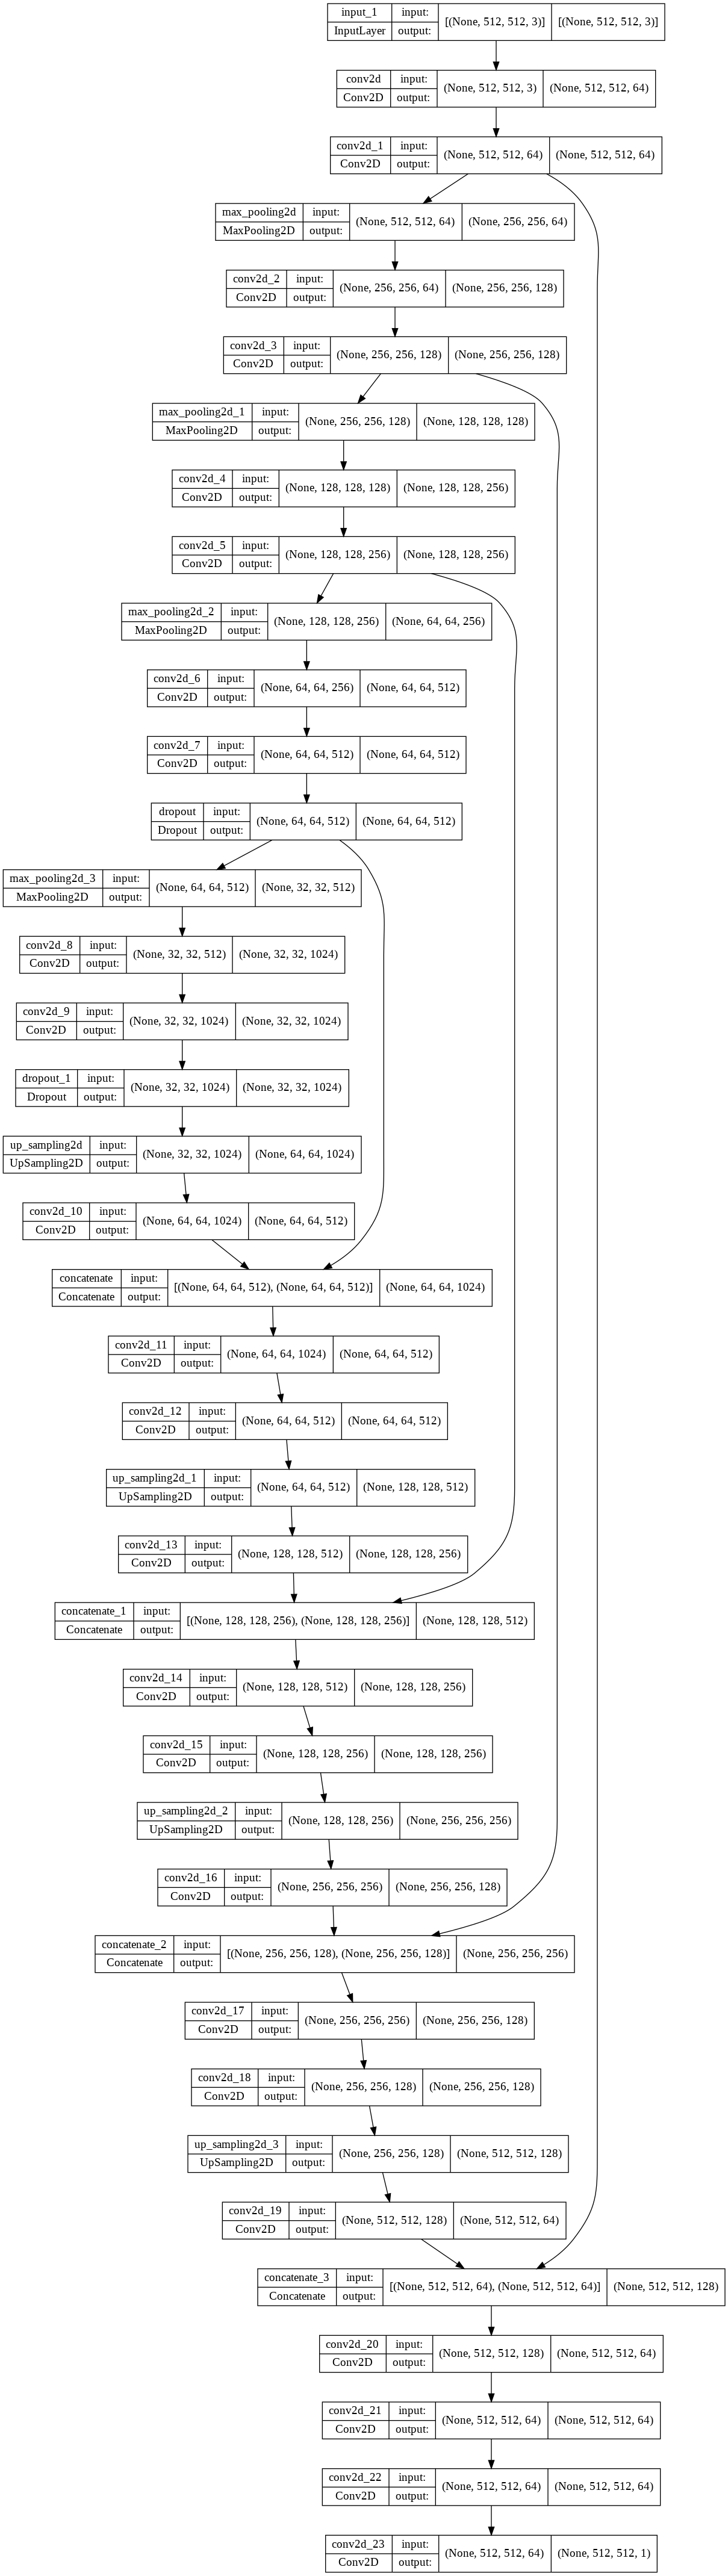

In [ ]:
tf.keras.utils.plot_model(model,show_shapes= True)

In [ ]:
model.compile(loss = 'binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              metrics = ['accuracy'])

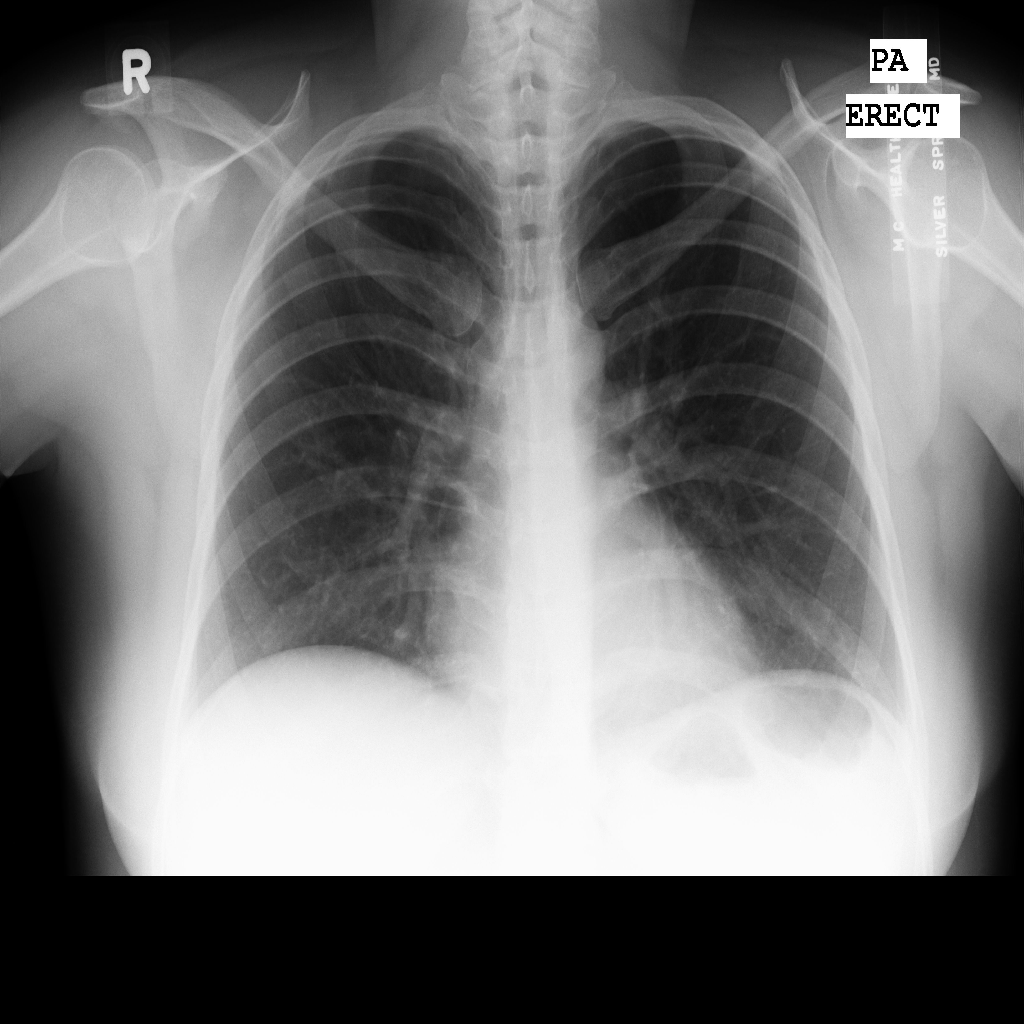

In [ ]:
# Load image
img = tf.keras.preprocessing.image.load_img('/content/MontgomerySet/CXR_png/MCUCXR_0001_0.png',
                                      target_size = (1024,1024))
img

In [ ]:
# Convert and scaling model
image_array = tf.keras.preprocessing.image.img_to_array(img)
image_array = np.expand_dims(image_array,axis =0)
print(image_array.shape)
image_array = image_array/255 

(1, 1024, 1024, 3)


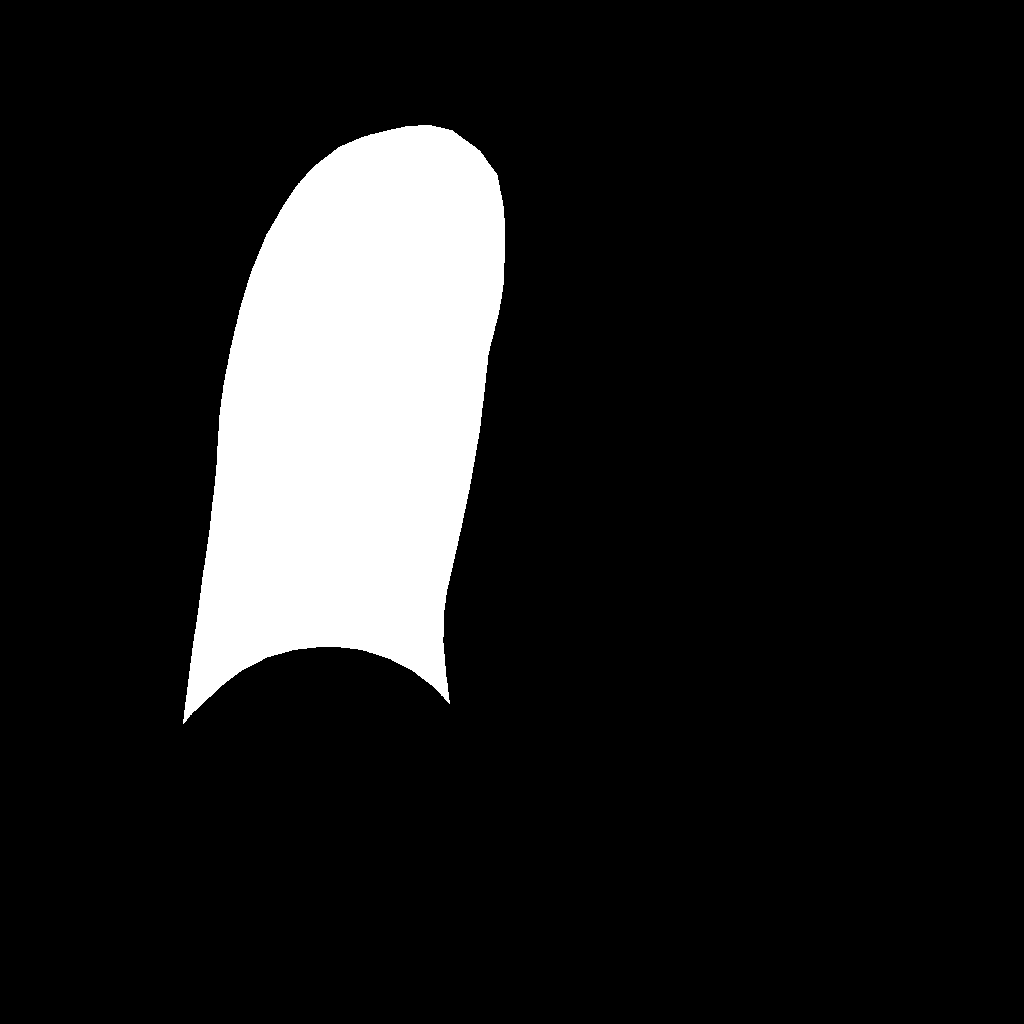

In [ ]:
mask = tf.keras.preprocessing.image.load_img('/content/MontgomerySet/ManualMask/leftMask/MCUCXR_0001_0.png',
                                      target_size = (1024,1024))
mask

In [ ]:
# Convert and scaling mask
mask_array = tf.keras.preprocessing.image.img_to_array(mask)
mask_array = np.expand_dims(mask_array,axis =0)
print(mask_array.shape)
mask_array = mask_array/255 

(1, 1024, 1024, 3)


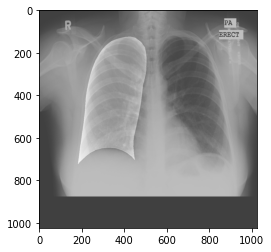

In [ ]:
plt.imshow(mask_array[0],alpha=0.5)
plt.imshow(image_array[0],alpha=0.5)

In [ ]:
def read_image(path,target_size = (512,512)):
    '''
    Read image from path ,Scale into [0:1] return tensor array
    path --- image path
    target_size --- resize the image into this size
    Return tensor array [None,H,W,3]
    '''
    image = tf.keras.preprocessing.image.load_img(path,target_size = target_size)
    image_tensor = tf.keras.preprocessing.image.img_to_array(image)
    image_tensor = image_tensor /255.
    #image_tensor = tf.expand_dims(image_tensor,axis = 0) 
    return image_tensor

In [ ]:
tensor = read_image('/content/MontgomerySet/CXR_png/MCUCXR_0001_0.png')
print(tensor.max())
tensor.shape

1.0


(512, 512, 3)

In [ ]:
def read_mask(path1,path2):
    '''
    Read left mask  and right mask then add them into 1 picture
    path1 --- left image path
    path2 --- right image path
    target_size --- resize the image into this size
    '''
    x1 = tf.keras.preprocessing.image.load_img(path1,target_size = (512,512))
    x1 = tf.keras.preprocessing.image.img_to_array(x1)
    x2 = tf.keras.preprocessing.image.load_img(path2,target_size = (512,512))
    x2 = tf.keras.preprocessing.image.img_to_array(x2)
    x = x1 + x2
    x = x.sum(axis =2)
    x = x/255. # Scale it
    x = (x > 0.5) *1
    x = x.reshape((512,512,1))
    return x

In [ ]:
mask = read_mask('/content/MontgomerySet/ManualMask/leftMask/MCUCXR_0001_0.png',
          '/content/MontgomerySet/ManualMask/rightMask/MCUCXR_0001_0.png')

print(mask.shape)
mask.max()

(512, 512, 1)


1

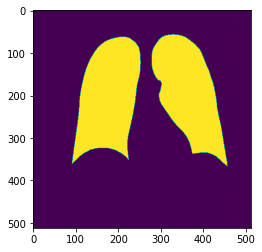

In [ ]:
plt.imshow(mask[:,:,0])

In [ ]:
from model import build_unet

In [ ]:
model1 = build_unet(input_shape = (512,512,3))
model1.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 512, 512, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d_24[0][0]']              
 alization)                     )                                                             

In [ ]:
pred =  model(tf.expand_dims(tensor,axis =0))

In [ ]:
pred1 =  model1(tf.expand_dims(tensor,axis =0))

In [ ]:
print(pred.shape)
print(pred1.shape)

(1, 512, 512, 1)
(1, 512, 512, 1)


In [ ]:
mask.shape

(512, 512, 1)

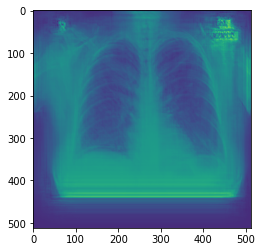

In [ ]:
plt.imshow(pred[0][:,:,0])
plt.savefig('model_output.png')

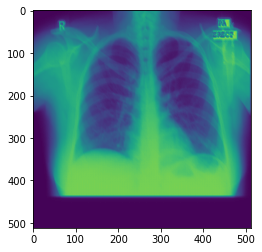

In [ ]:
plt.imshow(pred1[0][:,:,0])
plt.savefig('model1_output.png')

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits= True)

In [ ]:
loss(mask,pred[0]).numpy()

0.8914012

In [ ]:
print(tensor.shape)
print(mask.shape)

(512, 512, 3)
(512, 512, 1)


In [ ]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy']
              )

In [ ]:
train_x = np.asanyarray(tensor).astype('float32').reshape(1,512,512,3)
print(train_x.shape)
train_y = np.asanyarray(mask).astype('float32').reshape(1,512,512,1)
print(train_y.shape)

(1, 512, 512, 3)
(1, 512, 512, 1)


In [ ]:
model.fit(train_x,
          train_y,
          batch_size = 1,
          epochs = 1,
          verbose = 1
          )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1/1 [==============================] - 6s 6s/step - loss: 0.6999 - accuracy: 0.4953


In [ ]:
! python3 model.py

2022-04-21 08:57:15.633399: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                          

In [ ]:
import train
import metrics
from tqdm import tqdm

In [ ]:
(x_train,y1_train,y2_train),(x_valid,y1_valid,y2_valid),(x_test,y1_test,y2_test) = train.load_data('/content/MontgomerySet')

In [ ]:
x_train[0]

'/content/MontgomerySet/CXR_png/MCUCXR_0068_0.png'

In [ ]:
def make_data(x,y1,y2):
  X  =np.zeros(shape = (len(x),512,512,3))
  y = np.zeros(shape = (len(x),512,512,1))
  for i in tqdm(range(len(x))):
    X[i] = read_image(x[i],target_size = (512,512))
    y[i] = read_mask(y1[i],y2[i])
  return X,y

100%|██████████| 88/88 [00:28<00:00,  3.13it/s]


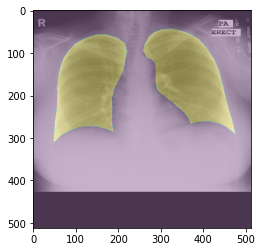

In [ ]:
X_train,y_train = make_data(x_train,y1_train,y2_train)
plt.imshow(X_train[0],alpha = 0.7)
plt.imshow(y_train[0][:,:,0],alpha = 0.3)
plt.savefig('train.png')

100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


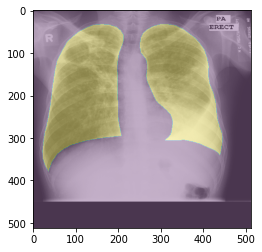

In [ ]:
X_valid,y_valid = make_data(x_valid,y1_valid,y2_valid)
plt.imshow(X_valid[0],alpha = 0.7)
plt.imshow(y_valid[0][:,:,0],alpha = 0.3)
plt.savefig('valid.png')

100%|██████████| 22/22 [00:07<00:00,  3.10it/s]


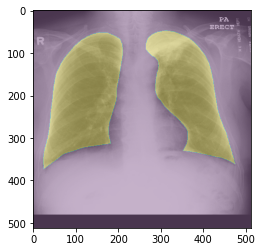

In [ ]:
X_test,y_test = make_data(x_test,y1_test,y2_test)
plt.imshow(X_test[0],alpha = 0.7)
plt.imshow(y_test[0][:,:,0],alpha = 0.3)
plt.savefig('test.png')

In [ ]:
model1.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
              metrics = ['accuracy']
              )

In [ ]:
history = model1.fit(X_train,y_train,
           epochs = 10,
           batch_size = 2, # OOM problem
           validation_data = (X_valid,y_valid),
           validation_steps = int(0.1*len(y_valid)),
           )

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


44/44 [==============================] - 288s 5s/step - loss: 0.4746 - accuracy: 0.7624 - val_loss: 0.7877 - val_accuracy: 0.2732
Epoch 2/10
44/44 [==============================] - 209s 5s/step - loss: 0.1942 - accuracy: 0.9294 - val_loss: 0.8597 - val_accuracy: 0.2732
Epoch 3/10
44/44 [==============================] - 211s 5s/step - loss: 0.0912 - accuracy: 0.9698 - val_loss: 0.7619 - val_accuracy: 0.3322
Epoch 4/10
44/44 [==============================] - 209s 5s/step - loss: 0.0783 - accuracy: 0.9741 - val_loss: 0.6133 - val_accuracy: 0.6898
Epoch 5/10
44/44 [==============================] - 209s 5s/step - loss: 0.0612 - accuracy: 0.9796 - val_loss: 0.6550 - val_accuracy: 0.7125
Epoch 6/10
44/44 [==============================] - 209s 5s/step - loss: 0.0608 - accuracy: 0.9789 - val_loss: 0.8926 - val_accuracy: 0.7240
Epoch 7/10
44/44 [==============================] - 209s 5s/step - loss: 0.0445 - accuracy: 0.9845 - val_loss: 1.0697 - val_accuracy: 0.7249
Epoch 8/10
44/44 [======

In [ ]:
model1.evaluate(X_test,y_test)

In [ ]:
import pandas as pd 

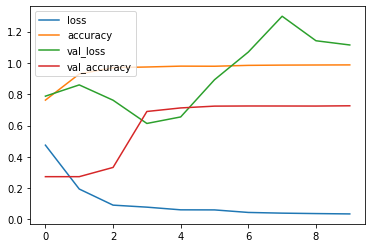

In [ ]:
pd.DataFrame(history.history).plot()
plt.savefig('./files/loss_curve.png')

In [ ]:
model1.save("./files/model_lung_unet1.h5")

# Predict & Evaluate model

https://ansvver.github.io/keras_save_model.html

In [1]:
from google.colab import drive
drive.mount('content')

Mounted at content


In [40]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import tensorflow as tf
import os 
import glob
import train 
import metrics 
import model
from tqdm import tqdm
from tensorflow.keras.utils import CustomObjectScope

In [16]:
# Set custom classes or functions in model with your custom definition
# with CustomObjectScope({'iou':metrics.iou,'dice_coef':metrics.dice_coef,'dice_loss':metrics.dice_loss}):
# model = tf.keras.models.load_model('/content/conbtent/MyDrive/model_lung_unet1.h5')
model = tf.keras.models.load_model('/content/content/MyDrive/model_lung_unet1.h5')

In [17]:
dir(model)

['_SCALAR_UPRANKING_ON',
 '_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_input_shape',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_defaults',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_cast_single_input',
 '_check_call_args',
 '_ch

(512, 512, 3)


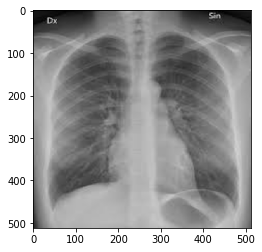

In [7]:
img_pred = train.read_image('/content/l1.jpg')
print(img_pred.shape)
plt.imshow(img_pred)

(1, 512, 512, 1)


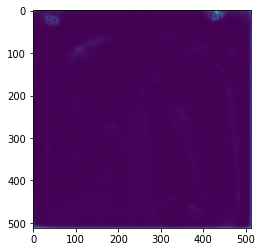

In [34]:
y_pred = model.predict(tf.expand_dims(img_pred,axis =0))
print(y_pred.shape)
#y_pred = (y_pred > 0.5)*1 
plt.imshow(y_pred[0][:,:,0])
#plt.imshow(img_pred,alpha = 0.5)

In [26]:
def predict_img(path,model,savedir = './predictions/',show = True,savefig = True):
  img_pred = train.read_image(path)
  img_name = path.split('/')[-1]
  img_name = img_name.split('.')[0]
  img_name = img_name + '_predicted'
  y_pred = model.predict(tf.expand_dims(img_pred,axis =0))
  if show:
    plt.title(img_name)
    plt.imshow(y_pred[0][:,:,0])
    # there is no image to save if you don't show anything
    if savefig:
      plt.savefig(savedir + img_name + '.png')
  return y_pred

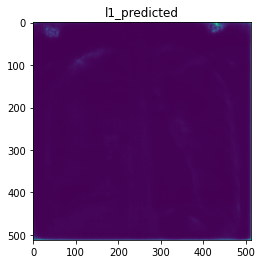

In [47]:
predict_img('/content/l1.jpg',model)

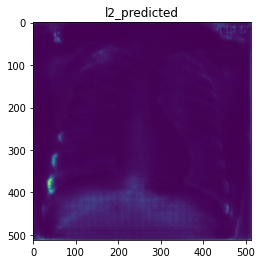

In [48]:
predict_img('/content/l2.jpg',model)

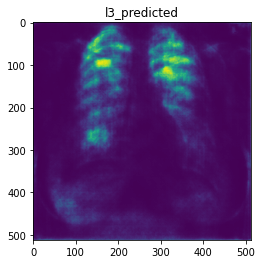

In [49]:
predict_img('/content/l3.jpg',model)

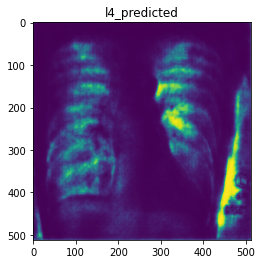

In [50]:
predict_img('/content/l4.jpg',model)

In [10]:
!unzip /content/content/MyDrive/NLM-MontgomeryCXRSet.zip

Archive:  /content/content/MyDrive/NLM-MontgomeryCXRSet.zip
   creating: MontgomerySet/
   creating: MontgomerySet/ClinicalReadings/
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0001_0.txt  
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0002_0.txt  
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0003_0.txt  
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0004_0.txt  
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0005_0.txt  
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0006_0.txt  
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0008_0.txt  
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0011_0.txt  
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0013_0.txt  
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0015_0.txt  
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0016_0.txt  
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0017_0.txt  
  inflating: MontgomerySet/ClinicalReadings/MCUCXR_0019_0.txt  
  inflating: MontgomerySet/Clinical

In [11]:
# load train valid test
(x_train,y1_train,y2_train),(x_valid,y1_valid,y2_valid),(x_test,y1_test,y2_test) = train.load_data(path = '/content/MontgomerySet')

In [25]:
train.create_dir('./results')

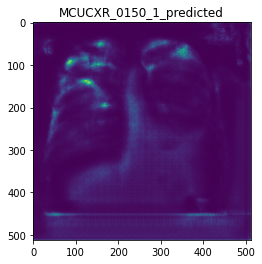

In [27]:
# Predicting the mask
y_pred = predict_img(x_valid[0],model,savedir = 'results',savefig = False)

In [29]:
print(y_pred.shape)
print(y_pred.max())

(1, 512, 512, 1)
0.6667032


(512, 512, 1)
1


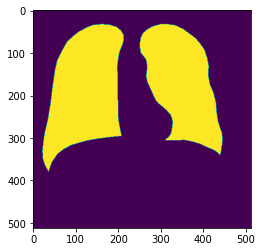

In [38]:
ground_truth = train.read_mask(y1_valid[0],y2_valid[0])
print(ground_truth.shape)
print(ground_truth.max())
plt.imshow(ground_truth[:,:,0])

In [32]:
f_loss = tf.keras.losses.BinaryCrossentropy()

In [36]:
f_loss(ground_truth,y_pred[0]).numpy()

1.1364156

In [44]:
model = tf.keras.mobdels.load_model('/content/content/MyDrive/model_lung_unet1.h5')

In [ ]:
def predict_img(path,model,savedir = './predictions/',show = True,savefig = True):
  img_pred = train.read_image(path)
  img_name = path.split('/')[-1]
  img_name = img_name.split('.')[0]
  img_name = img_name + '_predicted'
  y_pred = model.predict(tf.expand_dims(img_pred,axis =0))
  if show:
    plt.title(img_name)
    plt.imshow(y_pred[0][:,:,0])
    # there is no image to save if you don't show anything
    if savefig:
      plt.savefig(savedir + img_name + '.png')
  return y_pred

In [45]:
def slow_evaluate(x,y1,y2,model,path = './results/',savefig = True):
  f_loss = tf.keras.losses.BinaryCrossentropy() # Loss function
  losses = []
  for i in tqdm(range(len(x))):
    # Predicting the mask
    y_pred = predict_img(x[i],model,savedir = path,savefig = savefig)
    ground_truth = train.read_mask(y1[i],y2[i])
    losses.append(f_loss(ground_truth,y_pred[0]).numpy()) # storage loss value of this image
  print(f"Evaluated Mean loss: {np.mean(losses)}")
  return np.mean(losses)

100%|██████████| 28/28 [30:21<00:00, 65.07s/it]


Evaluated Mean loss: 1.1677930355072021


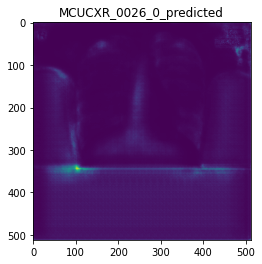

In [47]:
loss = slow_evaluate(x_valid,y1_valid,y2_valid,model)

In [48]:
x = train.read_image('/content/MCUCXR_0001_0.png')
y1 = train.read_image('/content/MCUCXR_0001_0_left_mask.png')
y2 = train.read_image('/content/MCUCXR_0001_0_right_mask.png')
print(x.shape)
print(y1.shape)
print(y2.shape)

(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


In [50]:
full = np.hstack([x,y1,y2])
print(full.shape)

(512, 1536, 3)


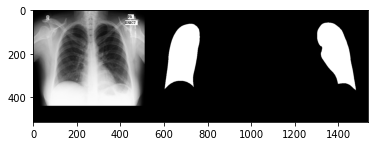

In [52]:
plt.imshow(full)
plt.savefig('input_mask.png')